In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import zipfile

!rm ./known -rf
fn = "/gdrive/My Drive/known.zip"
with zipfile.ZipFile(fn, 'r') as ff:
  ff.extractall('./')

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

print(tf.__version__) # 1.14.0
tf.test.is_gpu_available()

1.14.0


True

92 92 (512, 512, 4) (512, 512, 4)
(92, 512, 512, 1) (92, 512, 512, 1)


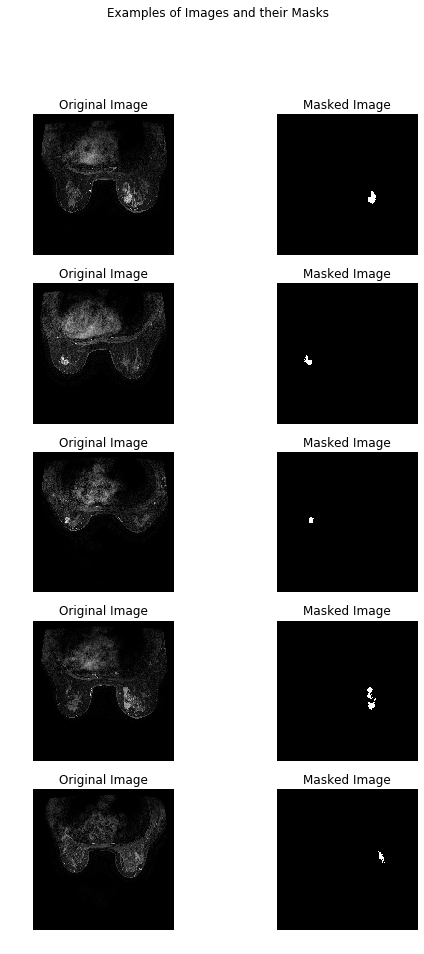

In [4]:
from skimage.filters.rank import enhance_contrast
from skimage.color import gray2rgb, rgb2gray
from skimage.morphology.selem import disk
from skimage.io import imread, ImageCollection

xx_name = tf.gfile.Glob('./known/dicom_png/*/*.png')
yy_name = [ii.replace('dicom_png', 'masks') for ii in xx_name]
print(len(xx_name), len(yy_name), plt.imread(xx_name[0]).shape, plt.imread(yy_name[0]).shape)
# 92 92 (512, 512, 4) (512, 512, 4)

def read_and_enhance_image(image_name, enhance=True):
    aa = imread(image_name)[:, :, 0]
    if enhance:
        aa = enhance_contrast(aa, disk(1))
    return np.expand_dims(aa / 255, -1)

xx_train = ImageCollection(xx_name, load_func=read_and_enhance_image, enhance=True).concatenate()
yy_train = ImageCollection(yy_name, load_func=read_and_enhance_image, enhance=False).concatenate()
print(xx_train.shape, yy_train.shape)
# (92, 512, 512, 1) (92, 512, 512, 1)

def random_display(xx, yy, display_num = 5):
    r_choices = np.random.choice(len(xx), display_num)
    fig = plt.figure(figsize=(8, 15))
    for ii, cc in enumerate(r_choices):
        plt.subplot(display_num, 2, ii * 2 + 1)
        plt.imshow(xx[cc, :, :, 0], cmap="gray")
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(display_num, 2, ii * 2 + 2)
        plt.imshow(yy[cc, :, :, 0], cmap="gray")
        plt.title("Masked Image")
        plt.axis('off')

    plt.suptitle("Examples of Images and their Masks")
    plt.show()

random_display(xx_train, yy_train)

In [5]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(xx_train, yy_train, test_size=0.2, random_state=42)
print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)
# (73, 512, 512, 1) (19, 512, 512, 1) (73, 512, 512, 1) (19, 512, 512, 1)

num_train_examples = train_x.shape[0]
num_val_examples = val_x.shape[0]

(73, 512, 512, 1) (19, 512, 512, 1) (73, 512, 512, 1) (19, 512, 512, 1)


In [6]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 3
aug = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

train_ds = (pair for pair in zip(aug.flow(train_x, batch_size=batch_size, seed=0), aug.flow(train_y, batch_size=batch_size, seed=0)))
val_ds = ImageDataGenerator().flow(val_x, val_y, batch_size=batch_size)

Using TensorFlow backend.


(3, 512, 512, 1) (3, 512, 512, 1)


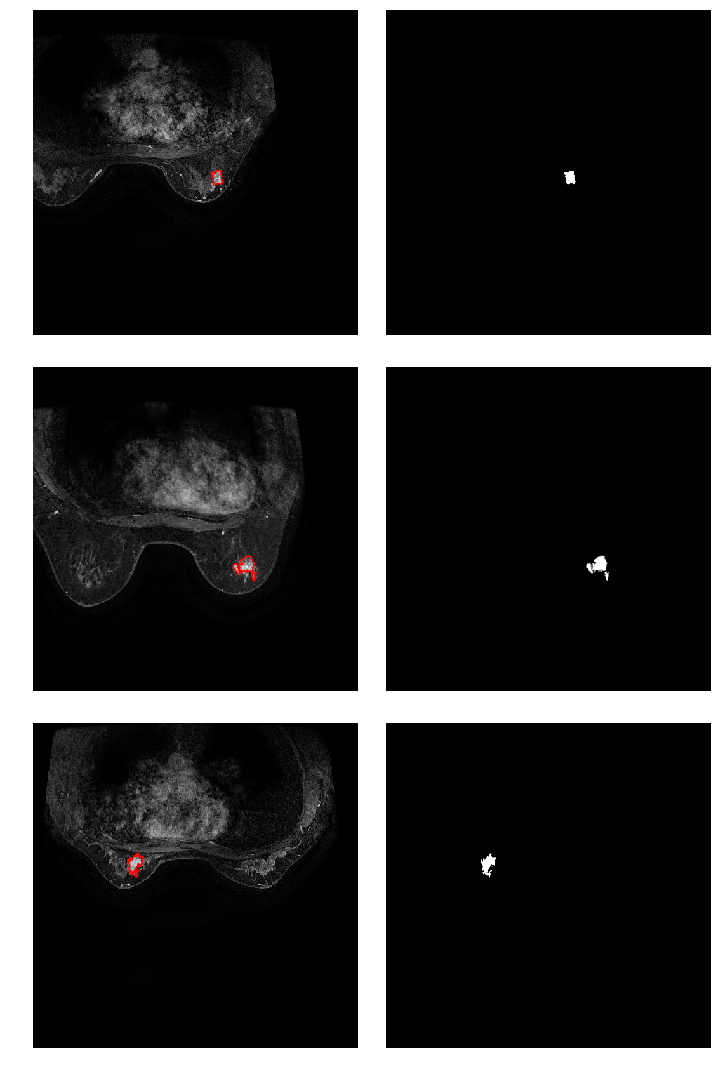

In [0]:
# Let's examine some of these augmented images
# Let's see if our image augmentor data pipeline is producing expected results
train_element_x, train_element_y = next(train_ds)
print(train_element_x.shape, train_element_y.shape)
# (3, 512, 512, 1) (3, 512, 512, 1)

# Running next element in our graph will produce a batch of images
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for xx, yy, ax in zip(train_element_x, train_element_y, axes):
    ax[0].imshow(xx[:, :, 0], cmap='gray')
    ax[0].contour(yy[:, :, 0], [0.5], colors='r')
    ax[0].set_axis_off()
    ax[1].imshow(yy[:, :, 0], cmap='gray')
    ax[1].set_axis_off()
fig.tight_layout()

In [0]:
# Original UNet realization
from tensorflow.python.keras import layers
from tensorflow.python.keras.utils import plot_model
img_shape = (512, 512, 1)

def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)

    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

def unet():
    inputs = layers.Input(shape=img_shape) # 256
    encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
    center = conv_block(encoder4_pool, 1024) # center
    decoder4 = decoder_block(center, encoder4, 512) # 16
    decoder3 = decoder_block(decoder4, encoder3, 256) # 32
    decoder2 = decoder_block(decoder3, encoder2, 128) # 64
    decoder1 = decoder_block(decoder2, encoder1, 64) # 128
    decoder0 = decoder_block(decoder1, encoder0, 32) # 256
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

    # Define your model

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    plot_model(model, to_file='Unet.png')
    return model

model = unet()

In [0]:
# ResUNet realization
from tensorflow.python.keras.layers.convolutional import Conv2D, ZeroPadding2D, Conv2DTranspose
from tensorflow.python.keras.layers.pooling import MaxPool2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.python.keras.layers import Dense, Flatten, Input, BatchNormalization, Dropout, Activation, Concatenate, concatenate, Add, UpSampling2D
from tensorflow.python.keras.utils import plot_model

def bn_act(x, act=True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((512, 512, 1))

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    plot_model(model, to_file='ResUNet.png')

    return model

model = ResUNet()

In [0]:
# MultiResUnet Realization
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    if(activation == None):
        return x
    x = Activation(activation, name=name)(x)

    return x

def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    return x

def MultiResBlock(U, inp, alpha = 1.67):
    W = alpha * U
    shortcut = inp
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) + int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3, activation='relu', padding='same')
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3, activation='relu', padding='same')
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3, activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):
        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')
        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)
    return out


def MultiResUnet(height, width, n_channels):
    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')

    model = Model(inputs=[inputs], outputs=[conv10])
    plot_model(model, to_file='MultiResUnet.png')
    return model

model = MultiResUnet(512, 512, 1)

In [7]:
# Resnet50 based UNet++ Realization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import copy

def to_tuple(x):
    if isinstance(x, tuple):
        if len(x) == 2:
            return x
    elif np.isscalar(x):
        return (x, x)

    raise ValueError('Value should be tuple of length 2 or int value, got "{}"'.format(x))

def get_layer_number(model, layer_name):
    for i, l in enumerate(model.layers):
        if l.name == layer_name:
            return i
    raise ValueError('No layer with name {} in  model {}.'.format(layer_name, model.name))

def handle_block_names(stage, cols):
    conv_name = 'decoder_stage{}-{}_conv'.format(stage, cols)
    bn_name = 'decoder_stage{}-{}_bn'.format(stage, cols)
    relu_name = 'decoder_stage{}-{}_relu'.format(stage, cols)
    up_name = 'decoder_stage{}-{}_upsample'.format(stage, cols)
    merge_name = 'merge_{}-{}'.format(stage, cols)
    return conv_name, bn_name, relu_name, up_name, merge_name

def ConvRelu(filters, kernel_size, use_batchnorm=False, conv_name='conv', bn_name='bn', relu_name='relu'):
    def layer(x):
        x = Conv2D(filters, kernel_size, padding="same", name=conv_name, use_bias=not(use_batchnorm))(x)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name)(x)
        x = Activation('relu', name=relu_name)(x)
        return x
    return layer

def Upsample2D_block(filters, stage, cols, kernel_size=(3,3), upsample_rate=(2,2), use_batchnorm=False, skip=None):
    def layer(input_tensor):
        conv_name, bn_name, relu_name, up_name, merge_name = handle_block_names(stage, cols)
        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)
        if (type(skip) != list and skip is not None) or (type(skip) == list and None not in skip):
            if type(skip) is list:
                x = Concatenate(name=merge_name)([x] + skip)
            else:
                x = Concatenate(name=merge_name)([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm, conv_name=conv_name + '1', bn_name=bn_name + '1', relu_name=relu_name + '1')(x)
        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm, conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer

def Transpose2D_block(filters, stage, cols, kernel_size=(3,3), upsample_rate=(2,2), transpose_kernel_size=(4,4), use_batchnorm=False, skip=None):
    def layer(input_tensor):
        conv_name, bn_name, relu_name, up_name, merge_name = handle_block_names(stage, cols)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate, padding='same', name=up_name, use_bias=not(use_batchnorm))(input_tensor)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        if (type(skip) != list and skip is not None) or (type(skip) == list and None not in skip):
            # print("\nskip = {}".format(skip))
            if type(skip) is list:
                merge_list = []
                merge_list.append(x)
                for l in skip:
                    merge_list.append(l)
                x = Concatenate(name=merge_name)(merge_list)
            else:
                x = Concatenate(name=merge_name)([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm, conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)
        return x
    return layer


def build_xnet(decoder_filters=(256,128,64,32,16),
               upsample_rates=(2,2,2,2,2),
               n_upsample_blocks=5,
               block_type='transpose',
               activation='sigmoid',
               use_batchnorm=True):

    classes = 1
    # block_type='upsampling'
    skip_connection_layers = ("activation_39", "activation_21", "activation_9", "activation",
                        "activation_48", "activation_24", "activation_12", "activation_3")
    backbone = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')

    input = backbone.input
    # print(n_upsample_blocks)

    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block

    if len(skip_connection_layers) > n_upsample_blocks:
        downsampling_layers = skip_connection_layers[int(len(skip_connection_layers)/2):]
        skip_connection_layers = skip_connection_layers[:int(len(skip_connection_layers)/2)]
    else:
        downsampling_layers = skip_connection_layers


    # convert layer names to indices
    skip_connection_idx = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                               for l in skip_connection_layers])
    skip_layers_list = [backbone.layers[skip_connection_idx[i]].output for i in range(len(skip_connection_idx))]
    downsampling_idx = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                               for l in downsampling_layers])
    downsampling_list = [backbone.layers[downsampling_idx[i]].output for i in range(len(downsampling_idx))]
    downterm = [None] * (n_upsample_blocks+1)
    for i in range(len(downsampling_idx)):
        # print(downsampling_list[0])
        # print(backbone.output)
        # print("")
        if downsampling_list[0] == backbone.output:
            # print("VGG16 should be!")
            downterm[n_upsample_blocks-i] = downsampling_list[i]
        else:
            downterm[n_upsample_blocks-i-1] = downsampling_list[i]
    downterm[-1] = backbone.output
    # print("downterm = {}".format(downterm))

    interm = [None] * (n_upsample_blocks+1) * (n_upsample_blocks+1)
    for i in range(len(skip_connection_idx)):
        interm[-i*(n_upsample_blocks+1)+(n_upsample_blocks+1)*(n_upsample_blocks-1)] = skip_layers_list[i]
    interm[(n_upsample_blocks+1)*n_upsample_blocks] = backbone.output

    for j in range(n_upsample_blocks):
        for i in range(n_upsample_blocks-j):
            upsample_rate = to_tuple(upsample_rates[i])
            # print(j, i)

            if i == 0 and j < n_upsample_blocks-1 and len(skip_connection_layers) < n_upsample_blocks:
                interm[(n_upsample_blocks+1)*i+j+1] = None
            elif j == 0:
                if downterm[i+1] is not None:
                    interm[(n_upsample_blocks+1)*i+j+1] = up_block(decoder_filters[n_upsample_blocks-i-2],
                                      i+1, j+1, upsample_rate=upsample_rate,
                                      skip=interm[(n_upsample_blocks+1)*i+j],
                                      use_batchnorm=use_batchnorm)(downterm[i+1])
                else:
                    interm[(n_upsample_blocks+1)*i+j+1] = None
                # print("\n{} = {} + {}\n".format(interm[(n_upsample_blocks+1)*i+j+1],
                #                             interm[(n_upsample_blocks+1)*i+j],
                #                             downterm[i+1]))
            else:
                interm[(n_upsample_blocks+1)*i+j+1] = up_block(decoder_filters[n_upsample_blocks-i-2],
                                  i+1, j+1, upsample_rate=upsample_rate,
                                  skip=interm[(n_upsample_blocks+1)*i : (n_upsample_blocks+1)*i+j+1],
                                  use_batchnorm=use_batchnorm)(interm[(n_upsample_blocks+1)*(i+1)+j])

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(interm[n_upsample_blocks])
    x = Activation(activation, name=activation)(x)

    model = Model(input, x)
    # plot_model(model, to_file='Resnet50_UNet++.png')
    return model

model = build_xnet()

from skimage.color import gray2rgb
batch_size = 3
aug = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

xx_train_3 = np.array([gray2rgb(ii[:, :, 0]) for ii in xx_train])
train_x_3, val_x_3, train_y, val_y = train_test_split(xx_train_3, yy_train, test_size=0.2, random_state=42)
train_ds = (pair for pair in zip(aug.flow(train_x_3, batch_size=batch_size, seed=0), aug.flow(train_y, batch_size=batch_size, seed=0)))
val_ds = ImageDataGenerator().flow(val_x_3, val_y, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss
    
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      


In [21]:
epochs = 50

SAVE_PATH = './training_checkpoints'
if not tf.gfile.Exists(SAVE_PATH): tf.gfile.MakeDirs(SAVE_PATH)
save_model_path = os.path.join(SAVE_PATH, 'weights.hdf5')
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)
history = model.fit_generator(train_ds,
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[checkpoints])

Epoch 1/50
24/25 [===========================>..] - ETA: 2s - loss: 1.2130 - dice_loss: 0.9789
Epoch 00001: val_dice_loss improved from inf to 0.99584, saving model to ./training_checkpoints/weights.hdf5
25/25 [==============================] - 90s 4s/step - loss: 1.2063 - dice_loss: 0.9788 - val_loss: 93.0131 - val_dice_loss: 0.9958
Epoch 2/50
24/25 [===========================>..] - ETA: 0s - loss: 0.8869 - dice_loss: 0.8595
Epoch 00002: val_dice_loss did not improve from 0.99584
25/25 [==============================] - 19s 778ms/step - loss: 0.8854 - dice_loss: 0.8585 - val_loss: 1.2566 - val_dice_loss: 0.9998
Epoch 3/50
24/25 [===========================>..] - ETA: 0s - loss: 0.4967 - dice_loss: 0.4901
Epoch 00003: val_dice_loss did not improve from 0.99584
25/25 [==============================] - 19s 779ms/step - loss: 0.4920 - dice_loss: 0.4853 - val_loss: 74.0559 - val_dice_loss: 0.9998
Epoch 4/50
24/25 [===========================>..] - ETA: 0s - loss: 0.3520 - dice_loss: 0.345

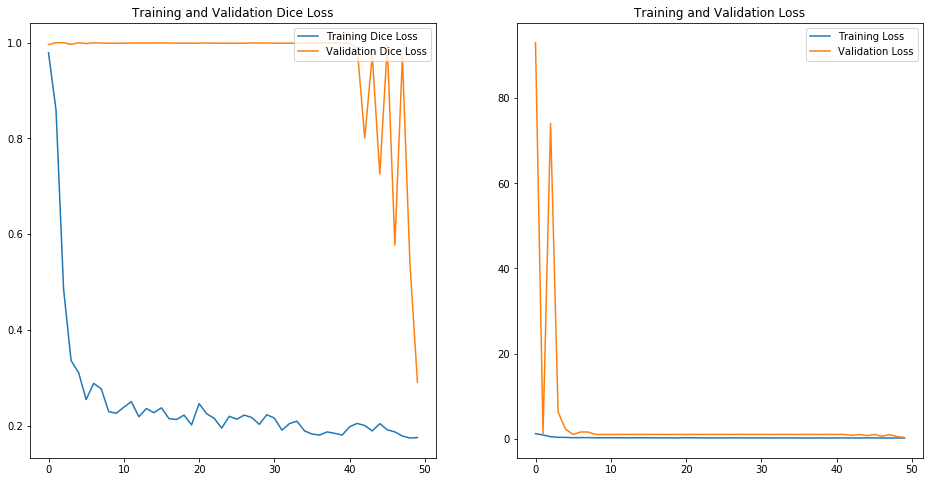

In [22]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [23]:
SAVE_PATH = './training_checkpoints'
save_model_path = os.path.join(SAVE_PATH, 'weights.hdf5')
model = tf.keras.models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_loss': dice_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


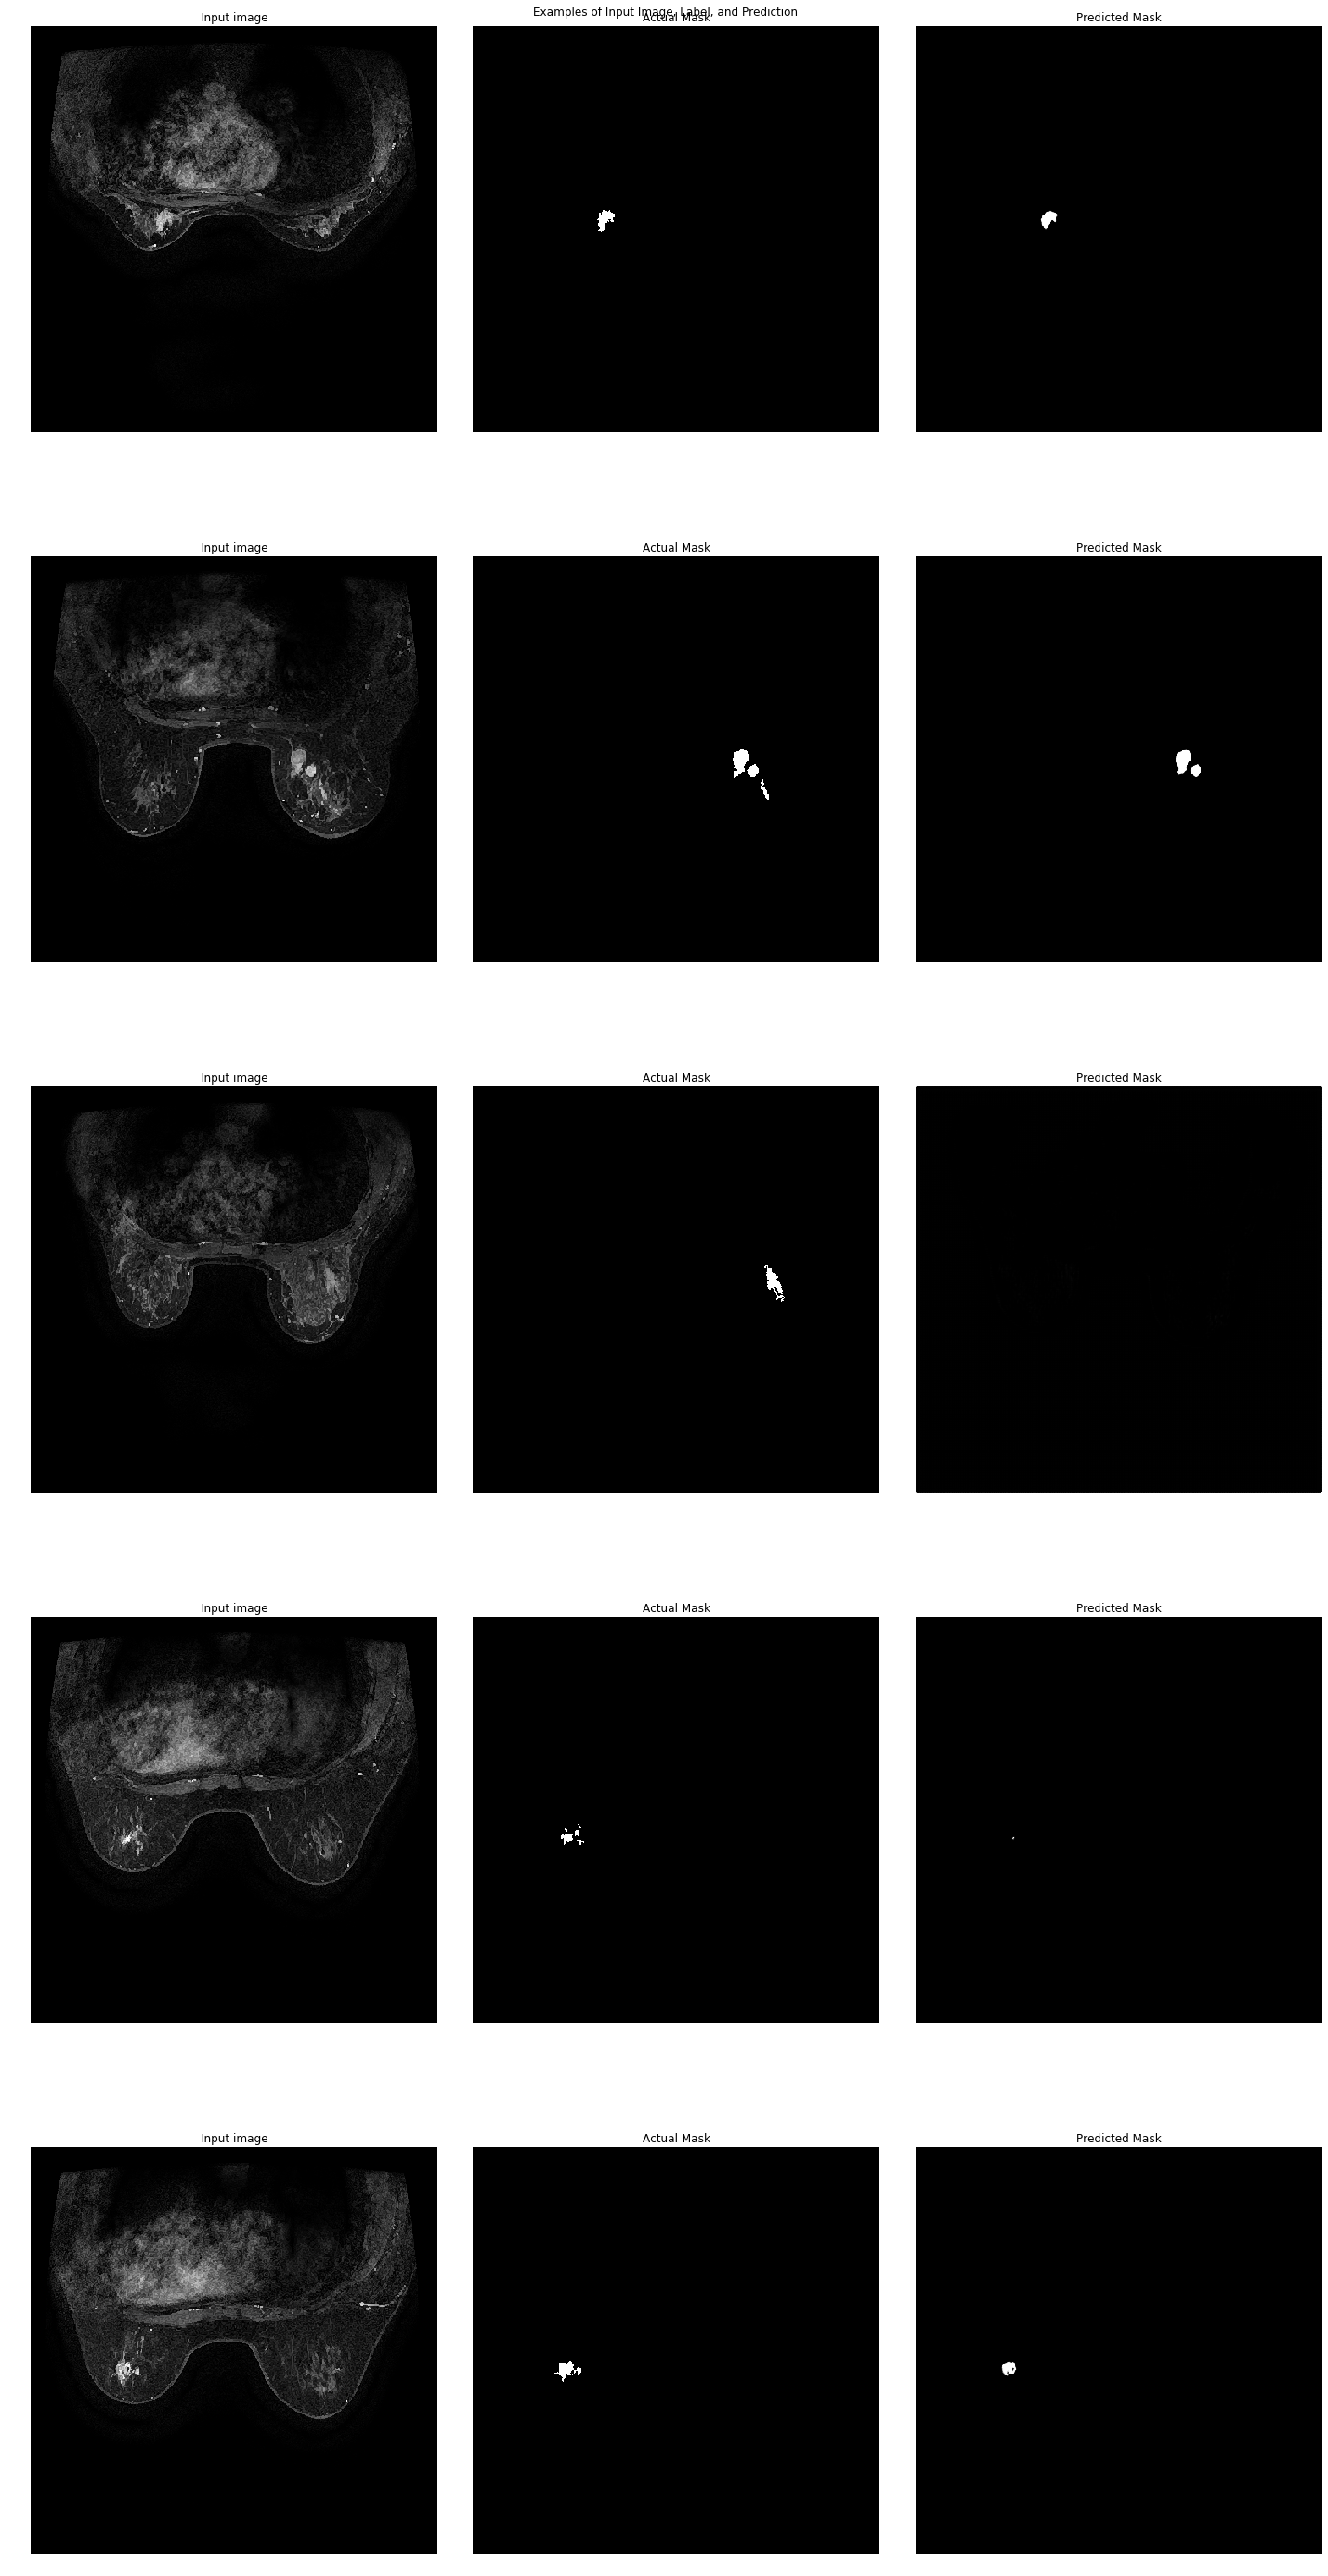

In [24]:
# Let's visualize some of the outputs
display_num = 5
r_choices = np.random.choice(len(xx_train), display_num)
xx_cc = xx_train_3[r_choices]
pred = model.predict(xx_cc)
fig = plt.figure(figsize=(20, 40))
for ii, cc in enumerate(r_choices):
    plt.subplot(display_num, 3, 3 * ii + 1)
    plt.imshow(xx_train[cc, :, :, 0], cmap="gray")
    plt.title("Input image")
    plt.axis('off')

    plt.subplot(display_num, 3, 3 * ii + 2)
    plt.imshow(yy_train[cc, :, :, 0], cmap="gray")
    plt.title("Actual Mask")
    plt.axis('off')

    plt.subplot(display_num, 3, 3 * ii + 3)
    plt.imshow(pred[ii, :, :, 0], cmap="gray")
    plt.title("Predicted Mask")
    plt.axis('off')
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.tight_layout()
plt.show()

In [0]:
tf.saved_model.simple_save(
    keras.backend.get_session(),
    "./1",
    inputs={'input_image': model.input},
    outputs={t.name:t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./2/saved_model.pb


In [0]:
# !cp training_checkpoints/weights.hdf5 /gdrive/My\ Drive/
!cp 1 /gdrive/My\ Drive/ -r

In [0]:
!sed -i "s/for inbound_layer in node.inbound_layers/for inbound_layer in nest.flatten(node.inbound_layers)/" /usr/local/lib/python3.6/dist-packages/keras/utils/vis_utils.py
!sed -i "77a\    from tensorflow.python.util import nest" /usr/local/lib/python3.6/dist-packages/keras/utils/vis_utils.py
!head -n 80 /usr/local/lib/python3.6/dist-packages/keras/utils/vis_utils.py | tail -n 10

from tensorflow import keras
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.python.keras import layers

resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
plot_model(resnet50, to_file='keras_resnet50.png')

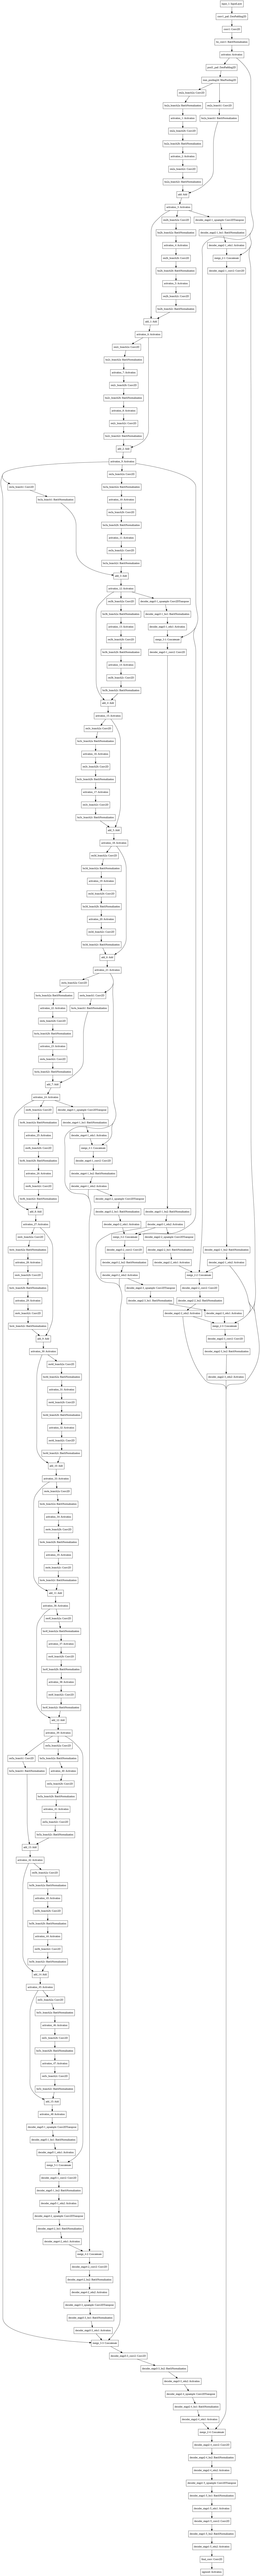

In [20]:
from importlib import reload
from keras.utils import vis_utils
reload(vis_utils)
vis_utils.plot_model(model, to_file='Resnet50_UNet++.png')

In [0]:
!git clone https://github.com/MrGiovanni/UNetPlusPlus.git
from UNetPlusPlus.segmentation_models import Unet, Nestnet, Xnet
model = Xnet(backbone_name='resnet50', input_shape=(512, 512, 3), encoder_weights='imagenet', decoder_block_type='transpose')

from UNetPlusPlus.segmentation_models import backbones
xx = backbones.ResNet50(input_shape=(None, None, 3), include_top=False)
from keras.utils.vis_utils import plot_model
plot_model(xx, to_file='xnet_resnet50.png')